# DIY COVID Dashboard

This DIY COVID-19 Dashboard aims to show - number of COVID cases, hospital admissions and deaths since the pandemic.

In [1]:
from IPython.display import clear_output
import ipywidgets as wdg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import requests
import time
import json

%matplotlib inline
# make figures larger
plt.rcParams['figure.dpi'] = 100

In [2]:
class APIwrapper:
    # class variables shared among all instances
    _access_point="https://api.ukhsa-dashboard.data.gov.uk"
    _last_access=0.0 # time of last api access
    
    def __init__(self, theme, sub_theme, topic, geography_type, geography, metric):
        """ Init the APIwrapper object, constructing the endpoint from the structure
        parameters """
        # build the path with all the required structure parameters. You do not need to edit this line,
        # parameters will be replaced by the actual values when you instantiate an object of the class!
        url_path=(f"/themes/{theme}/sub_themes/{sub_theme}/topics/{topic}/geography_types/" +
                  f"{geography_type}/geographies/{geography}/metrics/{metric}")
        # our starting API endpoint
        self._start_url=APIwrapper._access_point+url_path
        self._filters=None
        self._page_size=-1
        # will contain the number of items
        self.count=None

    def get_page(self, filters={}, page_size=10):
        
        # Check page size is within range
        if page_size>365:
            raise ValueError("Max supported page size is 365")
        # restart from first page if page or filters have changed
        if filters!=self._filters or page_size!=self._page_size:
            self._filters=filters
            self._page_size=page_size
            self._next_url=self._start_url
        # signal the end of data condition
        if self._next_url==None: 
            return [] # we already fetched the last page
        # simple rate limiting to avoid bans
        curr_time=time.time() # Unix time: number of seconds since the Epoch
        deltat=curr_time-APIwrapper._last_access
        if deltat<0.33: # max 3 requests/second
            time.sleep(0.33-deltat)
        APIwrapper._last_access=curr_time
        # build parameter dictionary by removing all the None
        # values from filters and adding page_size
        parameters={x: y for x, y in filters.items() if y!=None}
        parameters['page_size']=page_size
        # the page parameter is already included in _next_url.
        # This is the API access. Response is a dictionary with various keys.
        # the .json() method decodes the response into Python object (dictionaries,
        # lists; 'null' values are translated as None).
        response = requests.get(self._next_url, params=parameters).json()
        # update url so we'll fetch the next page
        self._next_url=response['next']
        self.count=response['count']
        # data are in the nested 'results' list
        return response['results'] 

    def get_all_pages(self, filters={}, page_size=365):
        
        data=[] # build up all data here
        while True:
            # use get_page to do the job, including the pacing
            next_page=self.get_page(filters, page_size)
            if next_page==[]:
                break # we are done
            data.extend(next_page)
        return data

In [3]:
structure={"theme": "infectious_disease", 
           "sub_theme": "respiratory",
           "topic": "COVID-19",
           "geography_type": "Nation", 
           "geography": "England"}

filters={"stratum" : None, # Smallest subgroup a metric can be broken down into e.g. ethnicity, testing pillar
         "age": None, # Smallest subgroup a metric can be broken down into e.g. 15_44 for the age group of 15-44 years
         "sex": None, #  Patient gender e.g. 'm' for Male, 'f' for Female or 'all' for all genders
         "year": 2020, #  Epi year of the metrics value (important for annual metrics) e.g. 2020
         "month": None, # Epi month of the metric value (important for monthly metrics) e.g. 12
         "epiweek" :None, # Epi week of the metric value (important for weekly metrics) e.g. 30
         "date" : None, # The date which this metric value was recorded in the format YYYY-MM-DD e.g. 2020-07-20
         "in_reporting_delay_period": None # Boolean indicating whether the data point is considered to be subject to retrospective updates
        }

In [4]:
# COVID-19 cases
structure["metric"]="COVID-19_cases_casesByDay" 

# ** unpacks the structure dictionary over the __init__ arguments
api=APIwrapper(**structure)
cases=api.get_all_pages()

# COVID-19 hospital admissions
structure["metric"]="COVID-19_healthcare_admissionByDay"

# ** unpacks the structure dictionary over the __init__ arguments
api=APIwrapper(**structure)
admissions=api.get_all_pages()

# COVID-19 deaths
structure["metric"]="COVID-19_deaths_ONSByDay"

# ** unpacks the structure dictionary over the __init__ arguments
api=APIwrapper(**structure)
deaths=api.get_all_pages()

In [5]:
with open("cases.json", "wt") as OUTF:
    json.dump(cases, OUTF)
    
with open("cases.json", "rt") as INFILE:
    cases=json.load(INFILE)

with open("admissions.json", "wt") as OUTF:
    json.dump(admissions, OUTF)
    
with open("admissions.json", "rt") as INFILE:
    admissions=json.load(INFILE)

with open("deaths.json", "wt") as OUTF:
    json.dump(deaths, OUTF)
    
with open("deaths.json", "rt") as INFILE:
    deaths=json.load(INFILE)

In [6]:
data={}
for dataset in [cases, admissions, deaths]:
    for entry in dataset:
        date=entry['date']
        metric=entry['metric']
        value=entry['metric_value']
        if date not in data:
            data[date]={}
        data[date][metric]=value

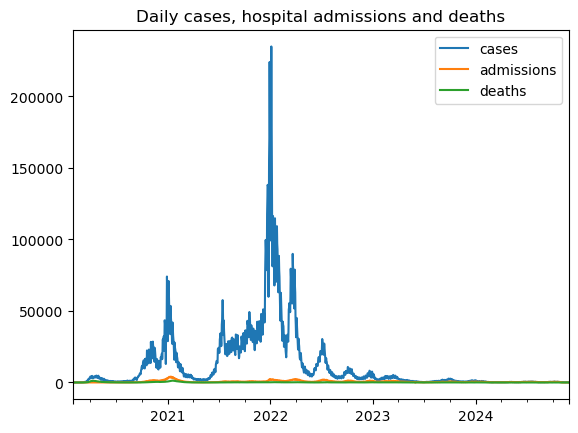

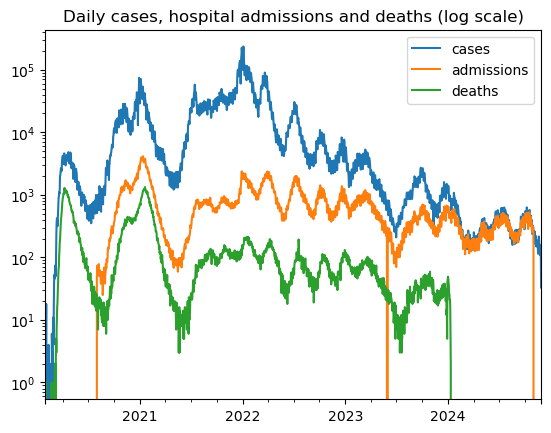

In [7]:
dates=list(data.keys())
dates.sort()

def parse_date(datestring):
    """ Convert a date string into a pandas datetime object """
    return pd.to_datetime(datestring, format="%Y-%m-%d")

startdate=parse_date(dates[0])
enddate=parse_date(dates[-1])

index=pd.date_range(startdate, enddate, freq='D')
timeseriesdf=pd.DataFrame(index=index, columns=['cases', 'admissions', 'deaths'])

# translate the columns to our metrics
metrics ={'cases': 'COVID-19_cases_casesByDay',
          'admissions': 'COVID-19_healthcare_admissionByDay',
          'deaths': 'COVID-19_deaths_ONSByDay'}

for date, entry in data.items(): # each entry is a dictionary with cases, admissions and deaths
    pd_date=parse_date(date) # convert to Pandas format
    for column in ['cases', 'admissions', 'deaths']: 
        metric_name=metrics[column]
        # do not assume all values are there for every date - if a value is not available, insert a 0.0
        value= entry.get(metric_name, 0.0)
        # this is the way you access a specific location in the dataframe - use .loc
        # and put index,column in a single set of [ ]
        timeseriesdf.loc[date, column]=value
            
# fill in any remaining "holes" due to missing dates
timeseriesdf.fillna(0.0, inplace=True)

ax=timeseriesdf.plot()
ax.set_title('Daily cases, hospital admissions and deaths');

ax=timeseriesdf.plot(logy=True)
ax.set_title('Daily cases, hospital admissions and deaths (log scale)');

def wrangle_data(data):
    """ Parameters: rawdata - data from json file or API call. Returns a dataframe.
    Edit to include the code that wrangles the data, creates the dataframe and fills it in. """
    df=pd.DataFrame(index=range(0,100), columns=['One', 'Two'])
    
    for entry in data:
        date = entry['date']
        metric = entry['metric']
        value = entry['metric_value']
        if date not in data:
            data[date] = {}
        data[date][metric] = value

    # Sort dates and create a DataFrame
    dates = sorted(data.keys())
    df = pd.DataFrame(index=pd.to_datetime(dates), columns=['cases'])

    # Map metrics to columns
    metric_name = 'COVID-19_cases_casesByDay'
    for date, metrics in data.items():
        df.loc[date, 'cases'] = metrics.get(metric_name, 0.0)

    metric_name = 'COVID-19_healthcare_admissionByDay'
    for date, metrics in data.items():
        df.loc[date, 'cases'] = metrics.get(metric_name, 0.0)

    metric_name = 'COVID-19_deaths_ONSByDay'
    for date, metrics in data.items():
        df.loc[date, 'cases'] = metrics.get(metric_name, 0.0)

    # Handle missing values
    df.fillna(0.0, inplace=True)
    
    return df

In [8]:
# Global DataFrame to store the processed data
df = pd.DataFrame()

# Function to access the API
def access_api():
    """
    Accesses the UKHSA API and fetches fresh data.
    Returns:
        list of dict: Data fetched from the API.
    """
    try:
        print("Accessing the UKHSA API...")
        url = "https://api.ukhsa-dashboard.data.gov.uk/themes/infectious_disease/sub_themes/respiratory/topics/COVID-19/geography_types/Nation/geographies/England/metrics/COVID-19_cases_casesByDay"
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad HTTP responses
        data = response.json()["results"]  # Parse the API response
        print("Data fetched successfully!")
        return data
    except requests.exceptions.RequestException as e:
        print(f"Error accessing API: {e}")
        return []  # Return an empty list on failure

# Callback for the button
def api_button_callback(button):
    """
    Callback function for the refresh button.
    """
    global df
    # Get fresh data from the API
    apidata = access_api()
    if not apidata:
        # API call failed
        apibutton.icon = "times"  # Change icon to indicate failure
        apibutton.description = "Unavailable"
        apibutton.button_style = "warning"
        return
    
    # Wrangle the data and update the global DataFrame
    df = wrangle_data(apidata)

    # Refresh the graph
    refresh_graph()

    # Update button icon to indicate success
    apibutton.icon = "check"
    apibutton.description = "Data Updated"

    
# Function to display the graph
def display_graph(dataframe):
    """
    Plots the data in the DataFrame.
    """
    if dataframe.empty:
        print("No data available to plot.")
        return
    
    plt.figure(figsize=(10, 6))
    dataframe['cases'].plot(marker='o', linestyle='-')
    plt.title("Daily COVID-19 Cases in England")
    plt.xlabel("Date")
    plt.ylabel("Number of Cases")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Create the button widget
apibutton = wdg.Button(
    description='Fetch API Data',
    disabled=False,
    button_style='info',  # 'success', 'info', 'warning', 'danger'
    tooltip="Fetch the latest COVID-19 data from UKHSA",
    icon='download'
)

# Register the callback function
apibutton.on_click(api_button_callback)

# Display the button
display(apibutton)

Button(button_style='info', description='Fetch API Data', icon='download', style=ButtonStyle(), tooltip='Fetch…

## Graphs

In [9]:
# Ensure df is defined initially
df = pd.DataFrame()  # Global DataFrame

# Function to load local data
def load_local_data():
    try:

        # Convert JSON to DataFrame
        cases_df = pd.DataFrame(cases)
        admissions_df = pd.DataFrame(admissions)
        deaths_df = pd.DataFrame(deaths)

        # Process DataFrames
        cases_df['date'] = pd.to_datetime(cases_df['date'])
        admissions_df['date'] = pd.to_datetime(admissions_df['date'])
        deaths_df['date'] = pd.to_datetime(deaths_df['date'])

        cases_df.rename(columns={'metric_value': 'cases'}, inplace=True)
        admissions_df.rename(columns={'metric_value': 'admissions'}, inplace=True)
        deaths_df.rename(columns={'metric_value': 'deaths'}, inplace=True)

        # Merge data
        merged_df = pd.merge(cases_df[['date', 'cases']], admissions_df[['date', 'admissions']], on='date', how='outer')
        merged_df = pd.merge(merged_df, deaths_df[['date', 'deaths']], on='date', how='outer')

        merged_df.fillna(0, inplace=True)
        merged_df.set_index('date', inplace=True)
        return merged_df
    except Exception as e:
        print(f"Error loading local data: {e}")
        return pd.DataFrame()

# Function to fetch data from the API
def fetch_api_data():
    """
    Fetches all data for cases, admissions, and deaths using APIWrapper.
    Returns:
        pd.DataFrame: Consolidated DataFrame.
    """
    print("Fetching data from the API...")
    metrics = {
        "cases": APIWrapper(
            theme="infectious_disease",
            sub_theme="respiratory",
            topic="COVID-19",
            geography_type="Nation",
            geography="England",
            metric="COVID-19_cases_casesByDay"
        ),
        "admissions": APIWrapper(
            theme="infectious_disease",
            sub_theme="respiratory",
            topic="COVID-19",
            geography_type="Nation",
            geography="England",
            metric="COVID-19_healthcare_admissionByDay"
        ),
        "deaths": APIWrapper(
            theme="infectious_disease",
            sub_theme="respiratory",
            topic="COVID-19",
            geography_type="Nation",
            geography="England",
            metric="COVID-19_deaths_ONSByDay"
        )
    }

    raw_data = {}
    for metric, wrapper in metrics.items():
        raw_data[metric] = wrapper.get_all_pages()

    # Consolidate into a DataFrame
    consolidated_data = []
    for metric, entries in raw_data.items():
        for entry in entries:
            entry['metric'] = metric
            consolidated_data.append(entry)
    return wrangle_data([consolidated_data])

# Wrangle data into a DataFrame
def wrangle_data(rawdata):
    data = {}
    for dataset in rawdata:
        for entry in dataset:
            date = entry['date']
            metric = entry['metric']
            value = entry['metric_value']
            if date not in data:
                data[date] = {}
            data[date][metric] = value

    # Create DataFrame
    dates = sorted(data.keys())
    df = pd.DataFrame(index=pd.to_datetime(dates), columns=['cases', 'admissions', 'deaths'])

    # Fill DataFrame
    for date, metrics in data.items():
        for col in df.columns:
            df.loc[date, col] = metrics.get(col, 0.0)

    # Ensure numeric values
    df.fillna(0.0, inplace=True)
    df = df.astype(float)
    return df

# Function to refresh data
def refresh_data(button):
    global df
    try:
        df = fetch_api_data()
        print("Data refreshed successfully!")
    except Exception as e:
        print(f"Error refreshing data: {e}")

# Plotting function
def plot_metric(metric):
    global df
    if df.empty:
        print("No data available to plot.")
        return
    if metric not in df.columns:
        print(f"Invalid metric: {metric}")
        return

    plt.figure(figsize=(10, 6))
    df[metric].plot(marker='o', linestyle='-', title=f"{metric.capitalize()} Over Time")
    plt.xlabel("Year")
    plt.ylabel("Count")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Initialize df with local data
df = load_local_data()

# Widgets
metric_selector = wdg.Dropdown(
    options=['cases', 'admissions', 'deaths'],
    value='cases',
    description='Metric:',
)

refresh_button = wdg.Button(
    description="Refresh Data",
    button_style='info',
    tooltip="Fetch the latest data from the API",
    icon='refresh'
)
refresh_button.on_click(refresh_data)

# Interactive graph
graph = wdg.interactive_output(plot_metric, {'metric': metric_selector})

# Display widgets and graph
display(refresh_button, metric_selector, graph)

Button(button_style='info', description='Refresh Data', icon='refresh', style=ButtonStyle(), tooltip='Fetch th…

Dropdown(description='Metric:', options=('cases', 'admissions', 'deaths'), value='cases')

Output()